[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5923 - loss: 0.6629 - val_accuracy: 0.6691 - val_loss: 0.5979
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7278 - loss: 0.5772 - val_accuracy: 0.8069 - val_loss: 0.5350
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8332 - loss: 0.5187 - val_accuracy: 0.8655 - val_loss: 0.4852
Epoch 4/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8798 - loss: 0.4704 - val_accuracy: 0.8805 - val_loss: 0.4455
Epoch 5/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8996 - loss: 0.4267 - val_accuracy: 0.8944 - val_loss: 0.4130
Epoch 6/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9095 - loss: 0.3964 - val_accuracy: 0.9032 - val_loss: 0.3862
Epoch 7/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9109 - loss: 0.3714 - val_accuracy: 0.9114 - val_loss: 0.3635
Epoch 8/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9210 - loss: 0.3471 - val_accuracy: 0

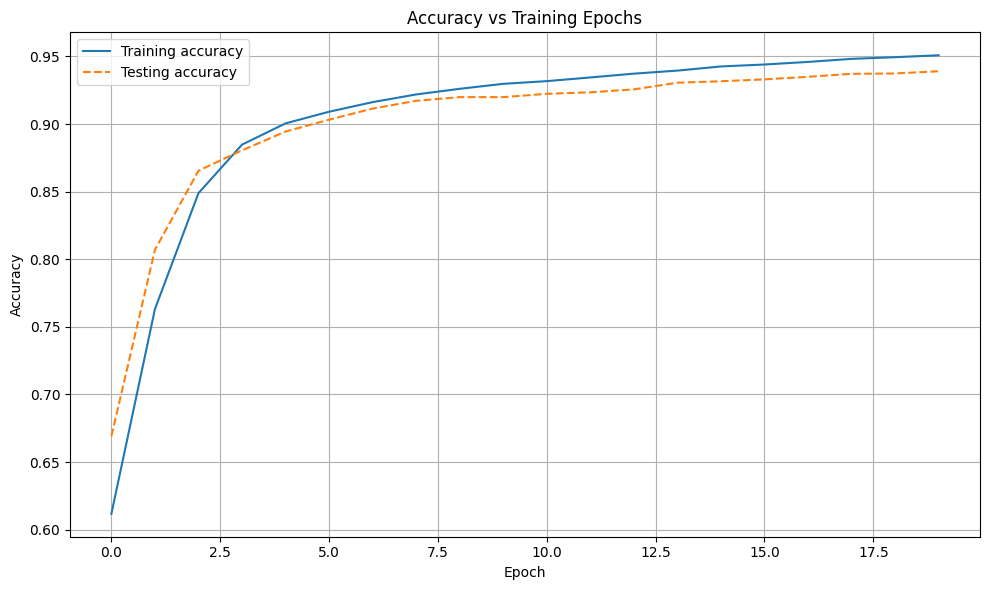

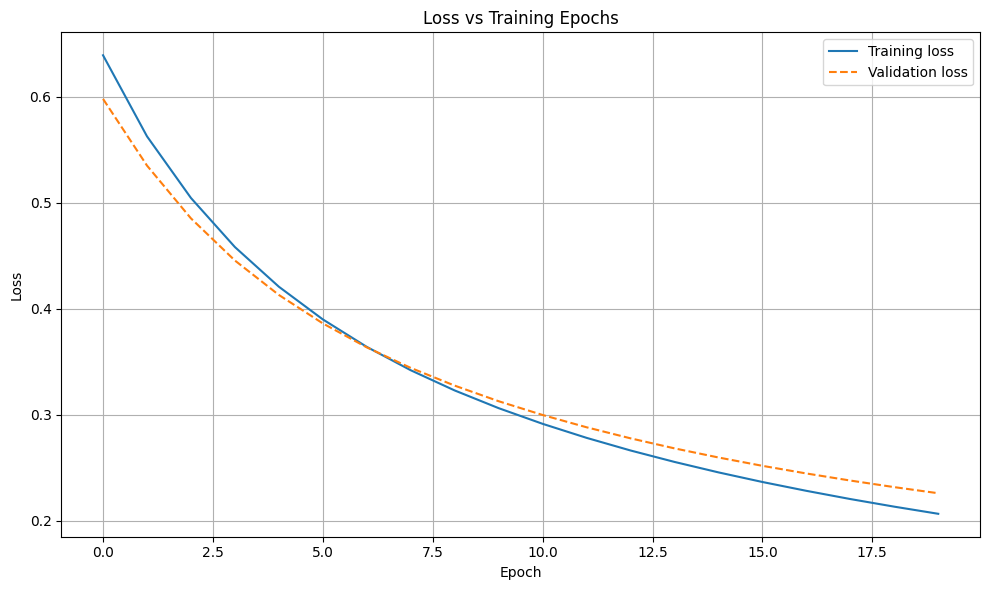

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


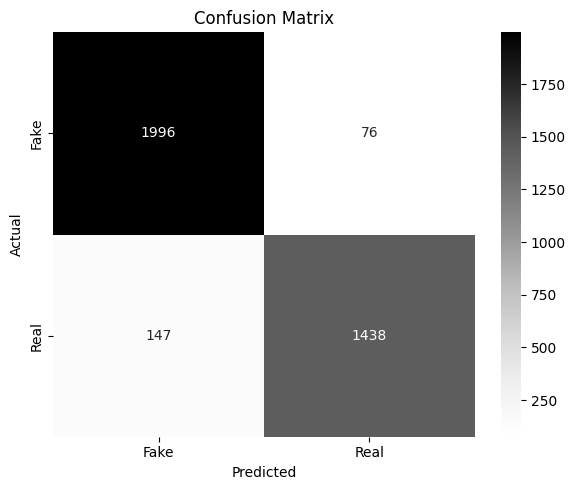

Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.96      0.95      2072
        Real       0.95      0.91      0.93      1585

    accuracy                           0.94      3657
   macro avg       0.94      0.94      0.94      3657
weighted avg       0.94      0.94      0.94      3657



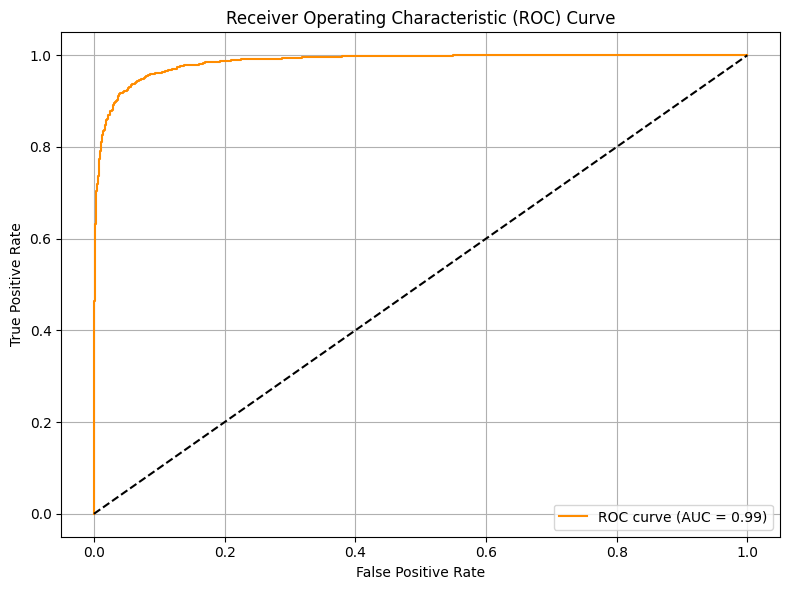

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer

# Download stopwords
nltk.download('stopwords')
stemmer = PorterStemmer()

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]
    return " ".join(text)

# Load dataset
df = pd.read_csv("train.csv")
df.dropna(inplace=True)
df['processed'] = df['text'].apply(preprocess_text)

# Encode labels and vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["processed"]).toarray()
y = LabelEncoder().fit_transform(df["label"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression Model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)],
    verbose=1
)

# ===== PLOTS =====
# 1. Accuracy Plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training accuracy', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Testing accuracy', linestyle='--')
plt.title('Accuracy vs Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation loss', linestyle='--')
plt.title('Loss vs Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Confusion Matrix
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 4. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# 5. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()